## Voting Classifier

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from matplotlib.gridspec import GridSpec
from scipy.special import boxcox1p

warnings.filterwarnings("ignore")

In [186]:
gender_submission = pd.read_csv("gender_submission.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

In [187]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [188]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [189]:
test["Survived"] = np.nan

In [190]:
dataset = pd.concat([train,test], axis = 0).reset_index(drop = True)
dataset = dataset.fillna(np.nan)

In [191]:
dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [192]:
dataset.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## EDA

In [193]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [194]:
def factorplot(param):
    sns.factorplot(x =param, size = 7, aspect = 2, data = train, y= "Survived", palette = "dark")
    plt.xlabel("\n" + param)
    plt.ylabel("Survival Probabilty\n")
    plt.show()
    
def factorplot_bar(param):
    sns.factorplot(x =param, size = 7, aspect = 2, data = train, y= "Survived", kind = "bar",palette = "dark")
    plt.xlabel("\n" + param)
    plt.ylabel("Survival Probabilty\n")
    plt.show()
    
def distplot(param):
    plt.figure(figsize=(20,8))
    sns.distplot(train[param], color = "steelblue", hist_kws={"rwidth":0.80, 'alpha':1.0})
    plt.xticks(np.arange(0,600,10),rotation=45)
    plt.xlabel('\n'+param)
    plt.ylabel('Distribution\n')
    plt.show()
    
def countplot(feature):
    plt.figure(figsize=(15,8))
    sns.countplot(data=train, x=feature,palette = "dark")
    plt.xlabel('\n' +feature)
    plt.ylabel('Number of Occurrences\n')
    plt.show()


def violineplot(param):
    plt.figure(figsize=(15,8))
    sns.violinplot(y=param,data=dataset,x='Survived',palette = "dark")
    plt.xlabel('\n'+param)
    plt.ylabel(param+'\n')
    plt.show()
    
def boxplot(x_param, y_param):
    plt.figure(figsize=(15,8))
    sns.boxplot(x=x_param, data=dataset,y=y_param, palette = "dark")
    plt.xlabel('\n'+ x_param)
    plt.ylabel(y_param + '\n')
    plt.show()

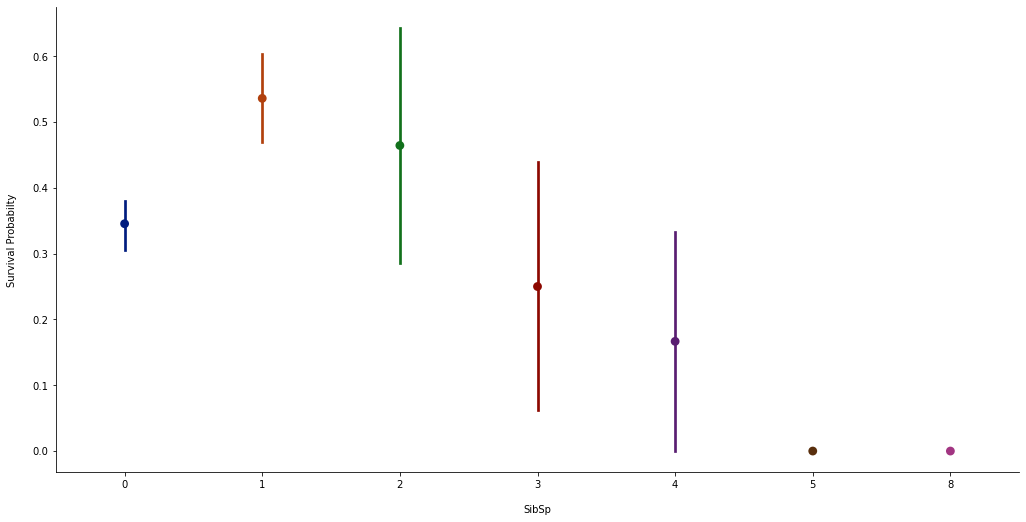

In [195]:
factorplot("SibSp")

smmall number of SibSp has higher probability to survive

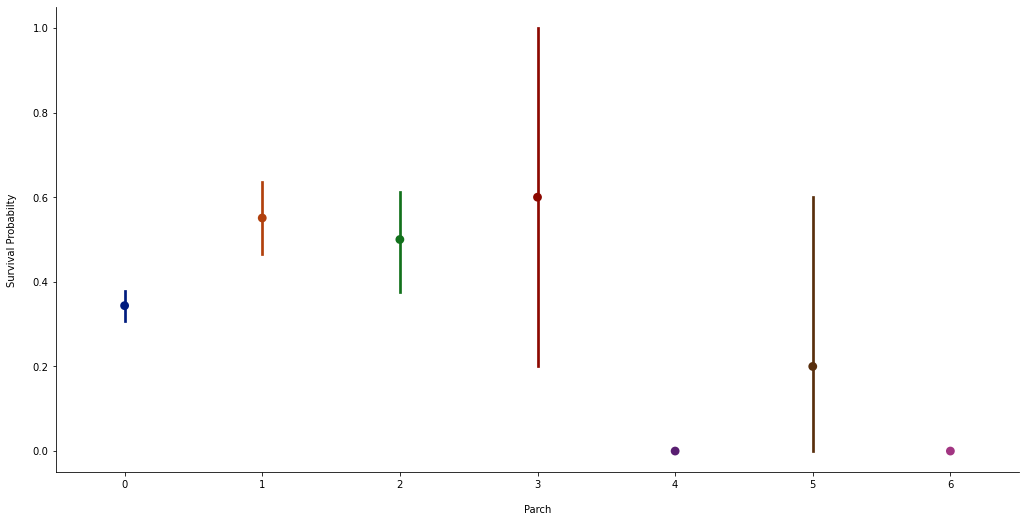

In [196]:
factorplot("Parch")

Small numbers of parch have high probablity to survive

In [197]:
dataset["Family"] = dataset["SibSp"] + dataset["Parch"] + 1
train["Family"] = train["SibSp"] + train["Parch"] + 1
test["Family"] = test["SibSp"] + test["Parch"] + 1

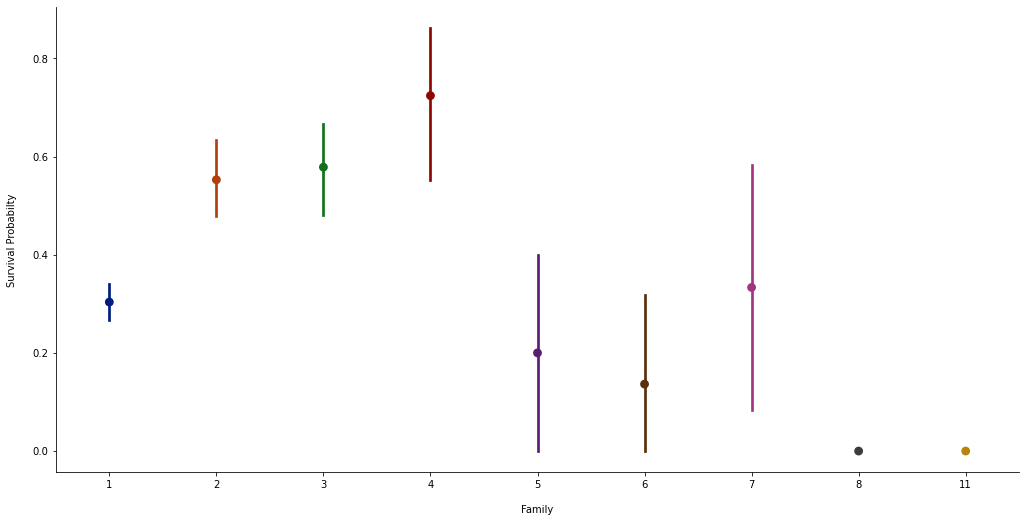

In [198]:
# Factorplot for family
factorplot("Family")

In [199]:
#removing SibSp and Parch as we have created new parameter "Family"
dataset = dataset.drop(columns=["SibSp", "Parch"])
train = train.drop(columns=["SibSp", "Parch"])
test = test.drop(columns=["SibSp", "Parch"])

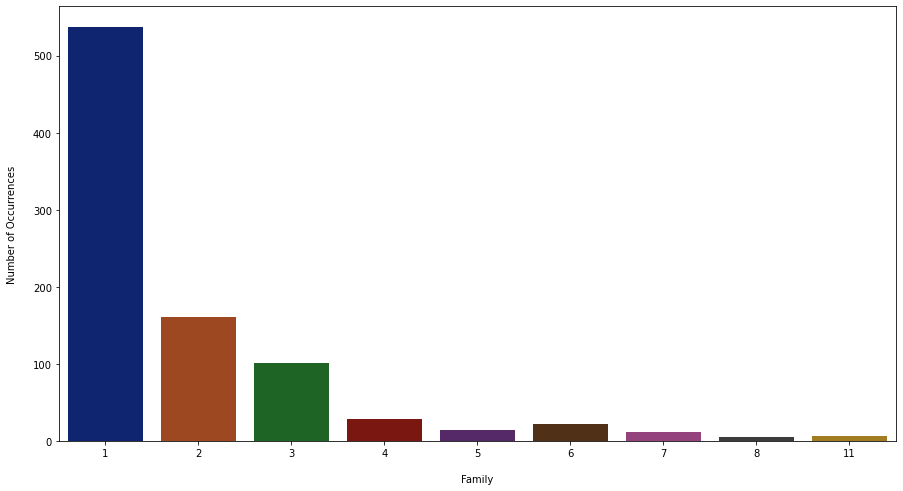

In [200]:
countplot("Family")

There are 11 different categories for Family , hence we can group them into following categories small, Medium, and large families

In [201]:
dataset.Family = list(map(lambda x: 'Big' if x > 4 else('Single' if x == 1 else 'Medium'), dataset.Family))
train.Family = list(map(lambda x: 'Big' if x > 4 else('Single' if x == 1 else 'Medium'), train.Family))
test.Family = list(map(lambda x: 'Big' if x > 4 else('Single' if x == 1 else 'Medium'), test.Family))

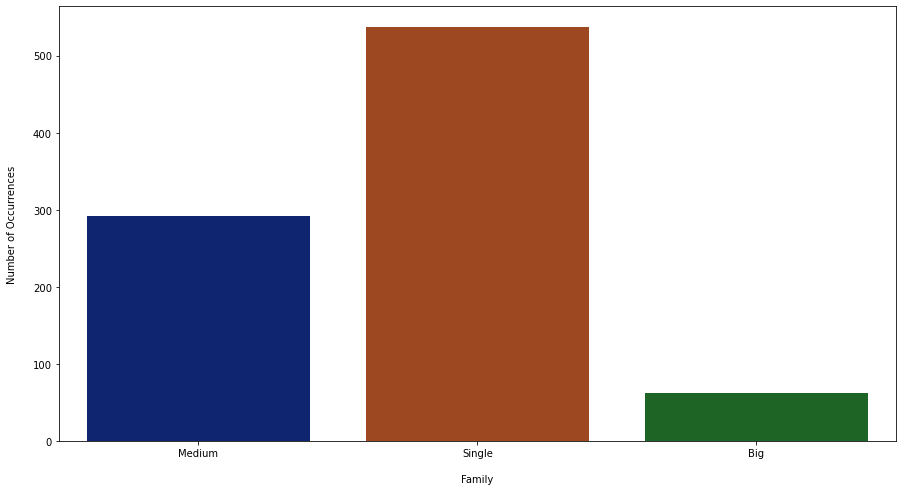

In [202]:
countplot("Family")

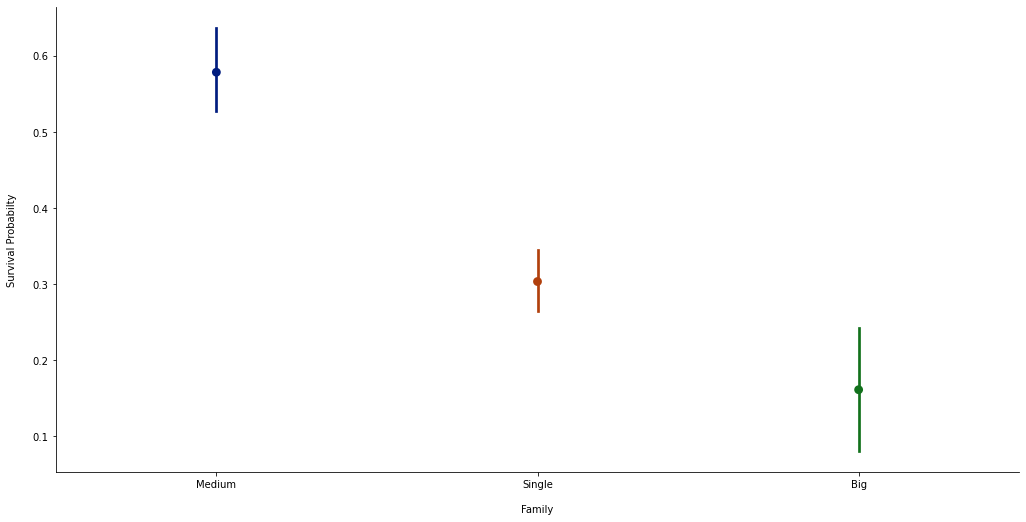

In [203]:
factorplot("Family")

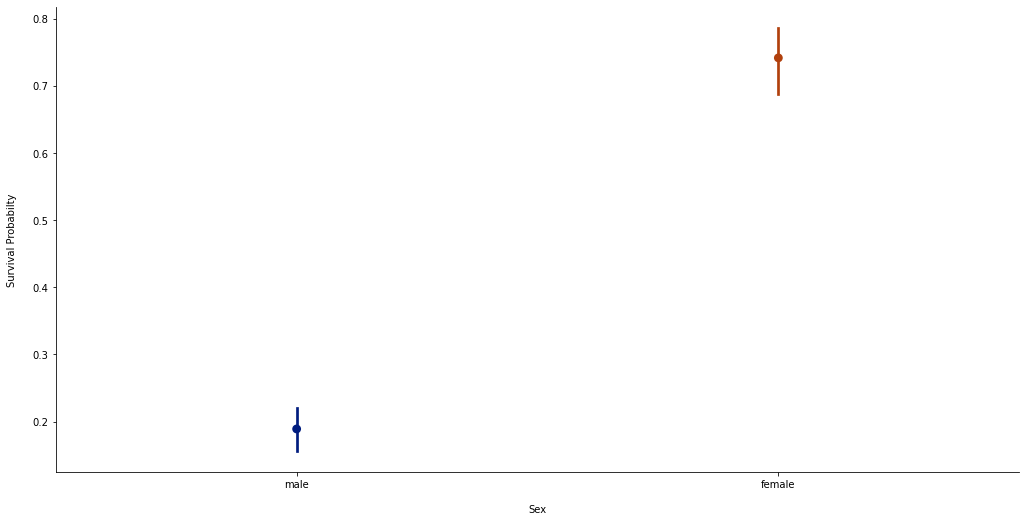

In [204]:
factorplot("Sex")

women has higher probability to survive

In [205]:
dataset.Sex = dataset.Sex.map({"male":0, "female":1})
train.Sex = train.Sex.map({"male":0, "female":1})
test.Sex = test.Sex.map({"male":0, "female":1})

In [206]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Family'],
      dtype='object')

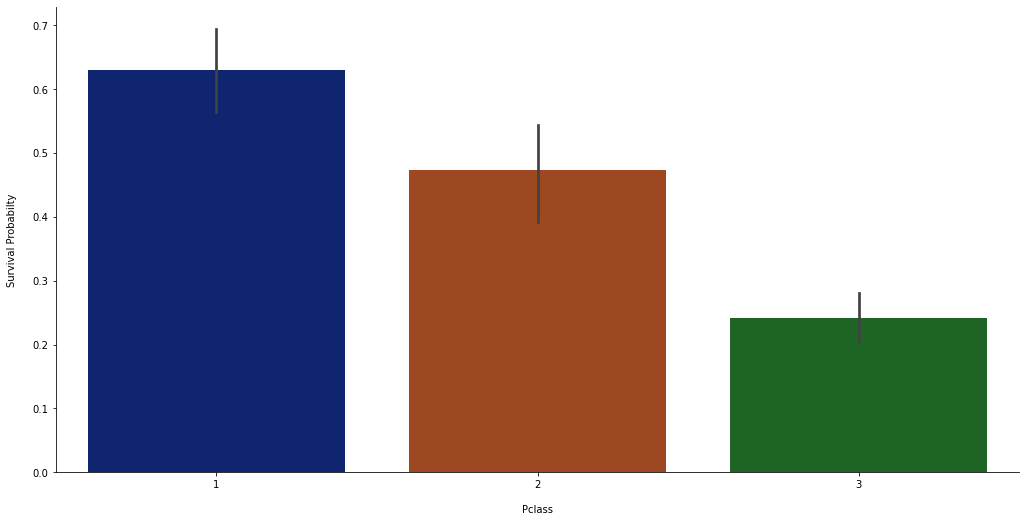

In [207]:
factorplot_bar("Pclass")

First class has a higher probability to survive

In [208]:
dataset.Fare.isnull().sum()

1

In [209]:
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())
train["Fare"] = train["Fare"].fillna(dataset["Fare"].median())
test["Fare"] = test["Fare"].fillna(dataset["Fare"].median())

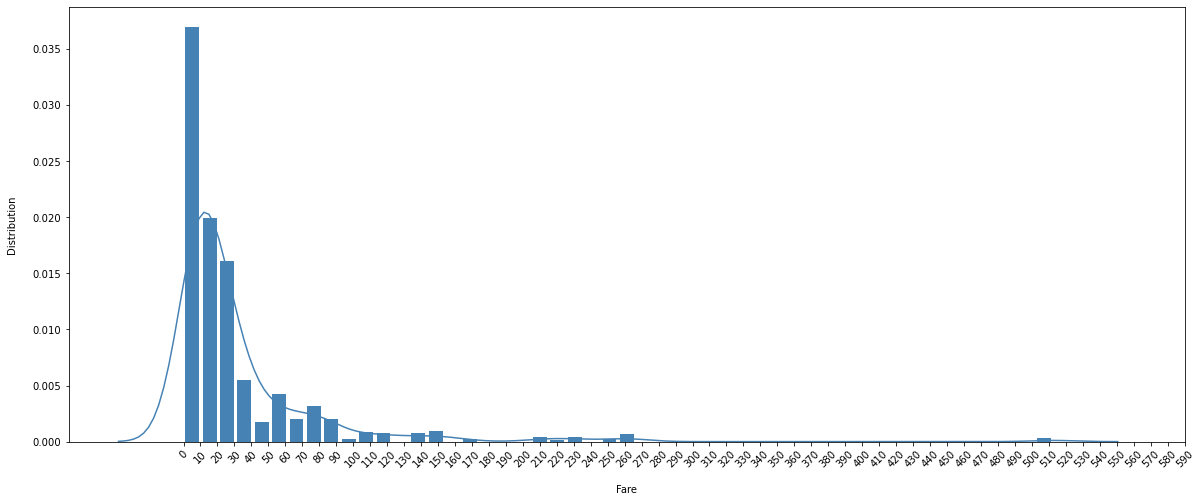

In [210]:
distplot("Fare")

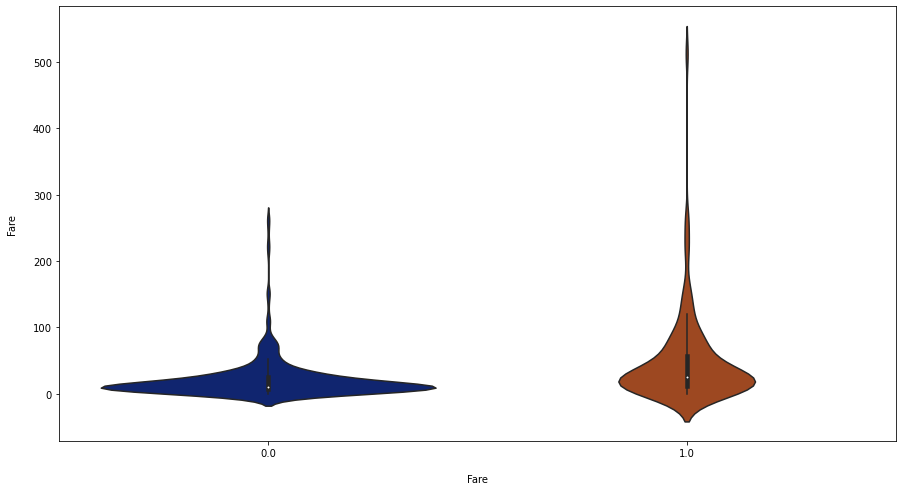

In [211]:
violineplot("Fare")

People who paid higher fare have higher probality to survive

In [212]:
dataset.Fare = list(map(lambda x: 'Very Low' if x <= 10 
         else('Low' if (x > 10 and x < 26) 
              else('Medium' if (x >= 26 and x <= 50) else 'High')), dataset.Fare))

train.Fare = list(map(lambda x: 'Very Low' if x <= 10 
         else('Low' if (x > 10 and x < 26) 
              else('Medium' if (x >= 26 and x <= 50) else 'High')), train.Fare))

test.Fare = list(map(lambda x: 'Very Low' if x <= 10 
         else('Low' if (x > 10 and x < 26) 
              else('Medium' if (x >= 26 and x <= 50) else 'High')), test.Fare))

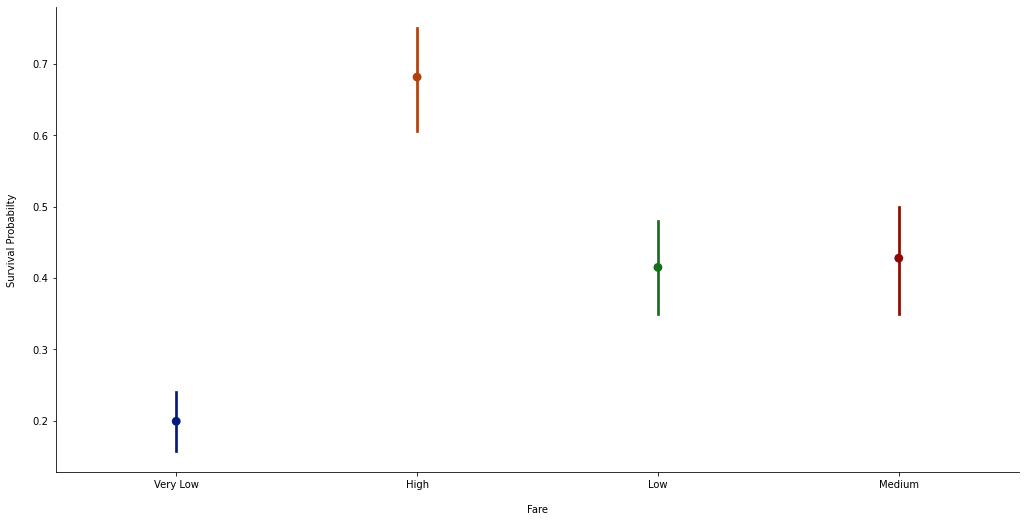

In [213]:
factorplot("Fare")

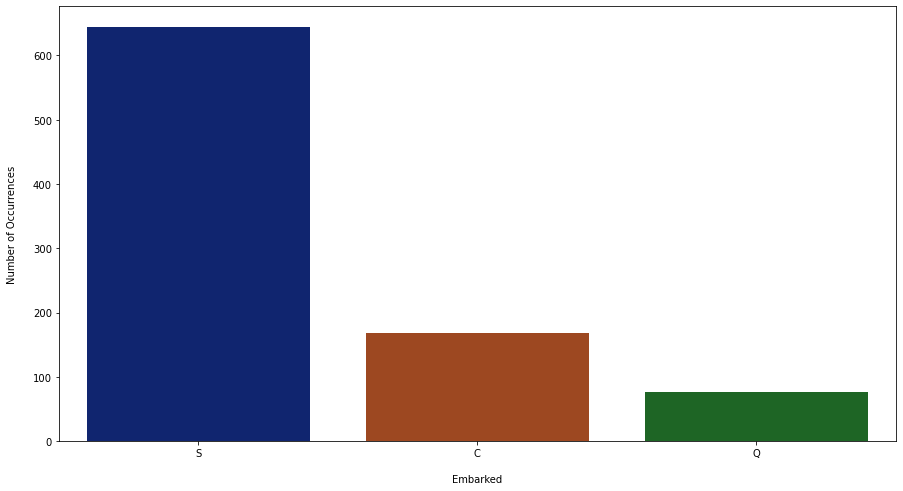

In [214]:
# Embarked
countplot("Embarked")

S is more frequent in the dataset

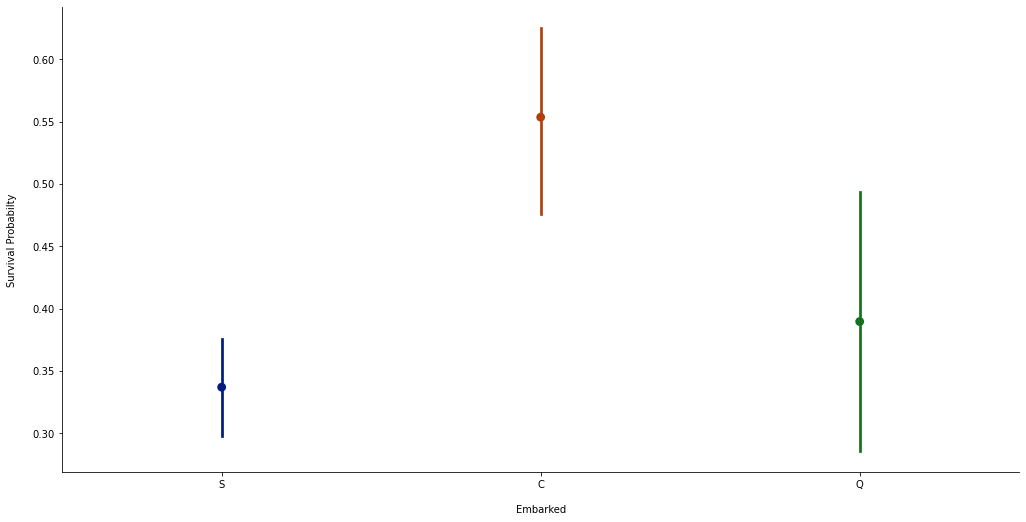

In [215]:
factorplot("Embarked")

In [216]:
dataset.Embarked.isnull().sum()

2

In [217]:
dataset.Embarked = dataset.Embarked.fillna('S')
train.Embarked = train.Embarked.fillna('S')
test.Embarked = test.Embarked.fillna('S')

In [218]:
#Name
title = []
for i in dataset.Name.str.split(', '):
    title.append(i[1].split('. ')[0])
dataset["Title"] = title

title = []
for i in train.Name.str.split(', '):
    title.append(i[1].split('. ')[0])
train["Title"] = title

title = []
for i in test.Name.str.split(', '):
    title.append(i[1].split('. ')[0])
test["Title"] = title

In [219]:
dataset = dataset.drop(columns=["Name"])
train = train.drop(columns=["Name"])
test = test.drop(columns=["Name"])

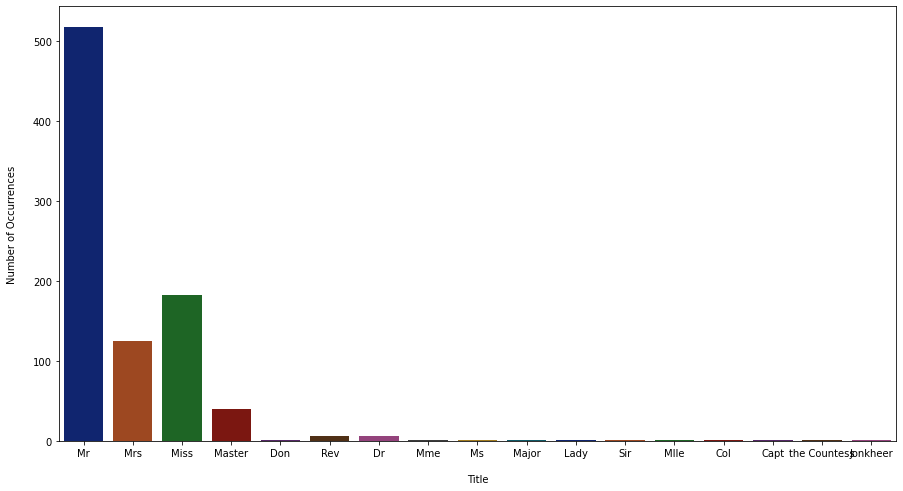

In [220]:
countplot("Title")

In [221]:
dataset.Title = list(map(lambda x: x if (x == 'Mr' or x == 'Mrs' or x == 'Miss')
         else('Other'), dataset.Title))

train.Title = list(map(lambda x: x if (x == 'Mr' or x == 'Mrs' or x == 'Miss')
         else('Other'), train.Title))

test.Title = list(map(lambda x: x if (x == 'Mr' or x == 'Mrs' or x == 'Miss')
         else 'Other', test.Title))

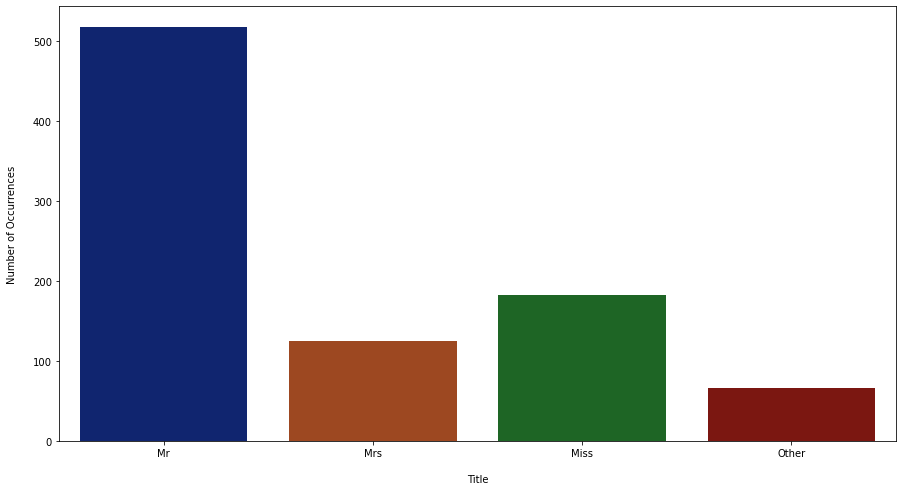

In [222]:
countplot("Title")

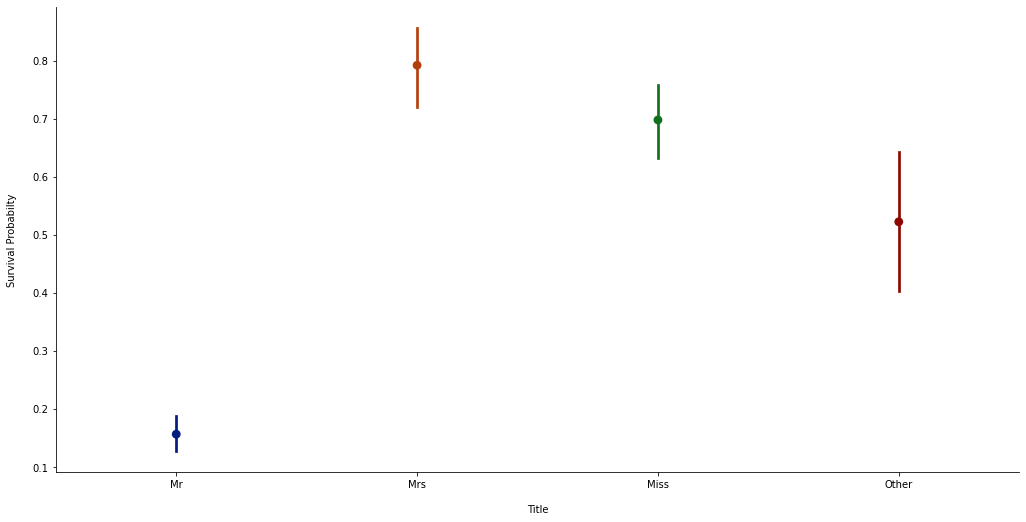

In [223]:
factorplot("Title")

In [224]:
train.Cabin.values[1][0]

'C'

In [225]:
cabin = []
for i in dataset.Cabin:
    if type(i) != float:
        cabin.append(i[0])
    else:
        cabin.append('Z')
dataset.Cabin = cabin

cabin = []
for i in train.Cabin:
    if type(i) != float:
        cabin.append(i[0])
    else:
        cabin.append('Z')
train.Cabin = cabin

cabin = []
for i in test.Cabin:
    if type(i) != float:
        cabin.append(i[0])
    else:
        cabin.append('Z')
test.Cabin = cabin

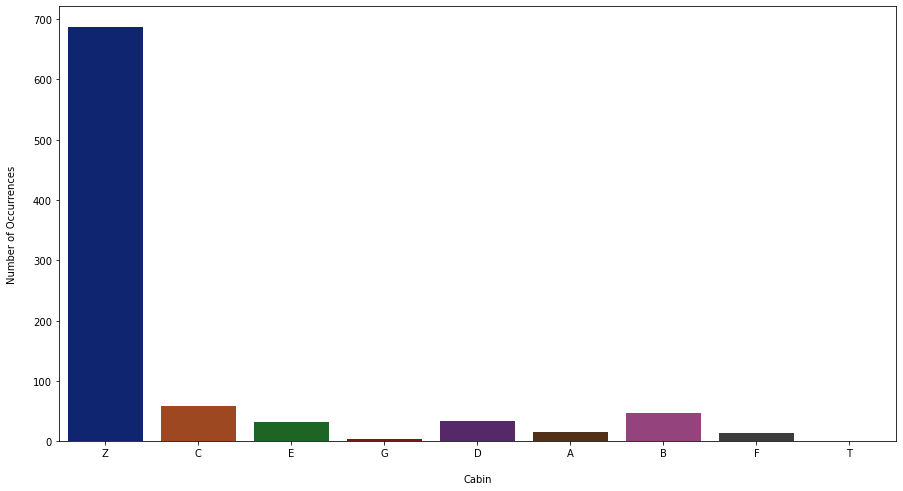

In [226]:
countplot("Cabin")

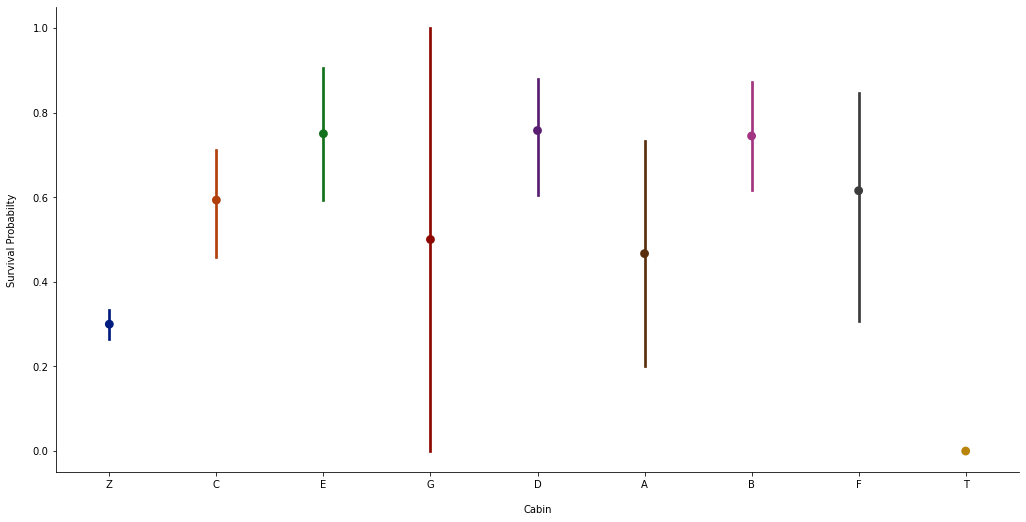

In [227]:
factorplot("Cabin")

It seems that people without cabines have less chance to survive, but standard deviations are large for some letters. We can group letters with similar behaviors.

In [228]:
dataset.Cabin = dataset.Cabin.map({'B':'BCDE','C':'BCDE','D':'BCDE','E':'BCDE','A':'AFG','F':'AFG','G':'AFG','Z':'Z','T':'Z'})
train.Cabin = train.Cabin.map({'B':'BCDE','C':'BCDE','D':'BCDE','E':'BCDE','A':'AFG','F':'AFG','G':'AFG','Z':'Z','T':'Z'})
test.Cabin = test.Cabin.map({'B':'BCDE','C':'BCDE','D':'BCDE','E':'BCDE','A':'AFG','F':'AFG','G':'AFG','Z':'Z','T':'Z'})

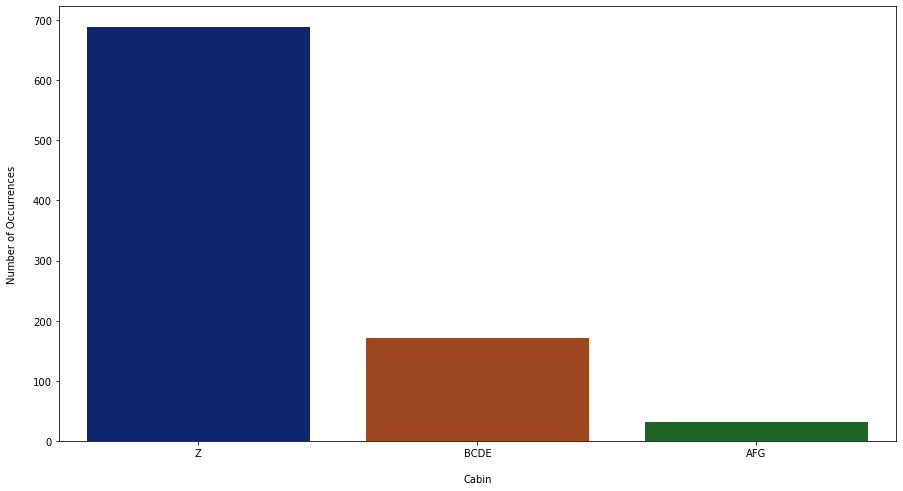

In [229]:
countplot("Cabin")

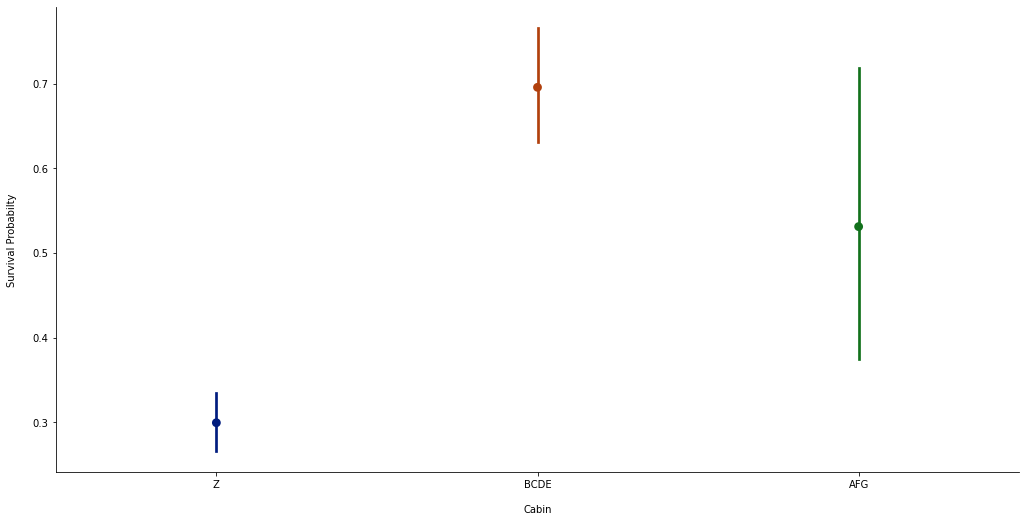

In [230]:
factorplot("Cabin")

In [231]:
tickets = []
for i in dataset.Ticket:
    tickets.append(i.split(' ')[-1][0])
dataset.Ticket = tickets

tickets = []
for i in train.Ticket:
    tickets.append(i.split(' ')[-1][0])
train.Ticket = tickets

tickets = []
for i in test.Ticket:
    tickets.append(i.split(' ')[-1][0])
test.Ticket = tickets

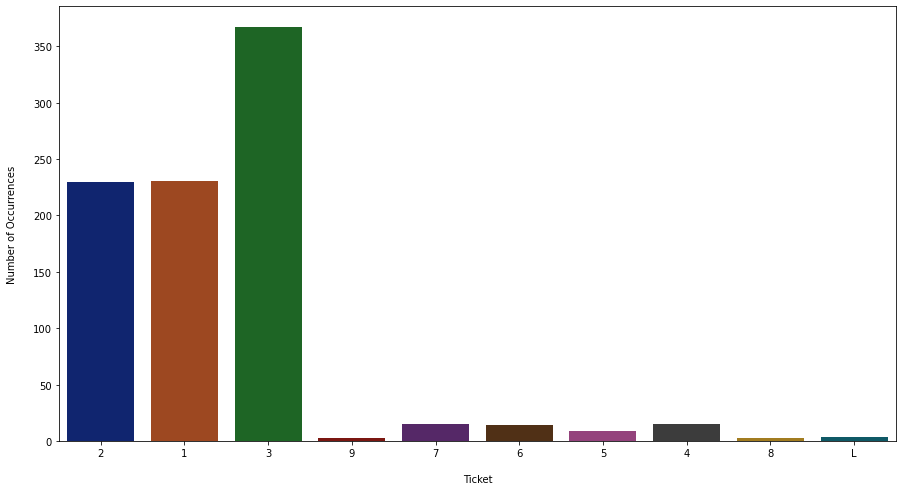

In [232]:
countplot("Ticket")

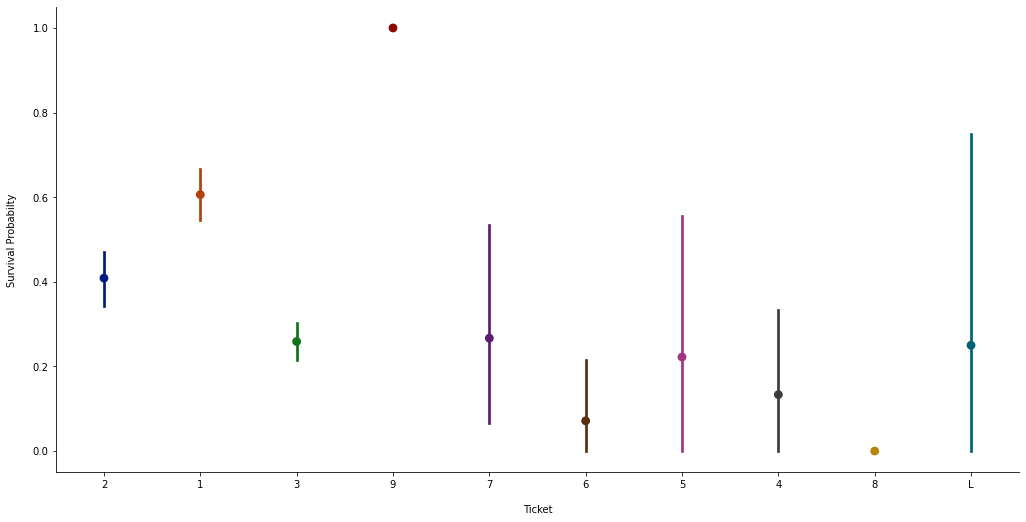

In [233]:
factorplot("Ticket")

Since 1, 2 and 3 have more occurrences and the others have large standard deviations, we can group these into one category.

In [234]:
dataset.Ticket = list(map(lambda x: 4 if (x == 'L' or int(x) >= 4) else int(x), dataset.Ticket))
train.Ticket = list(map(lambda x: 4 if (x == 'L' or int(x) >= 4) else int(x), train.Ticket))
test.Ticket = list(map(lambda x: 4 if (x == 'L' or int(x) >= 4) else int(x), test.Ticket))


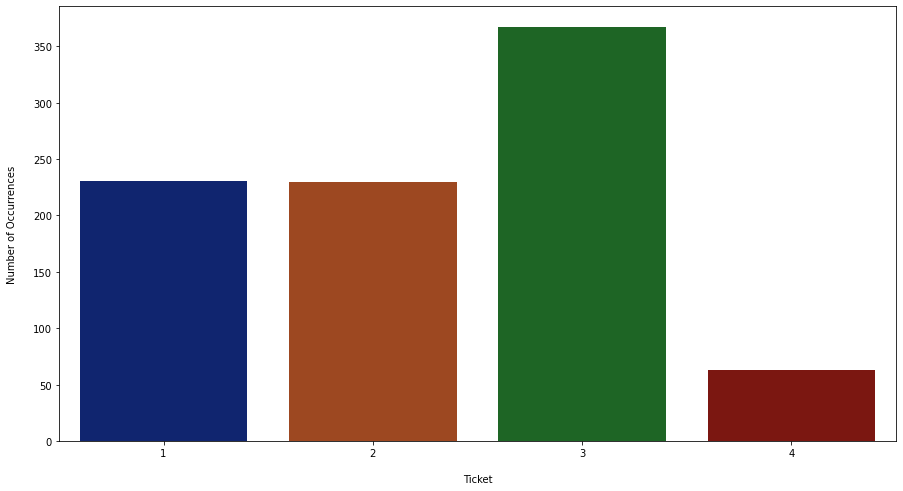

In [235]:
countplot("Ticket")

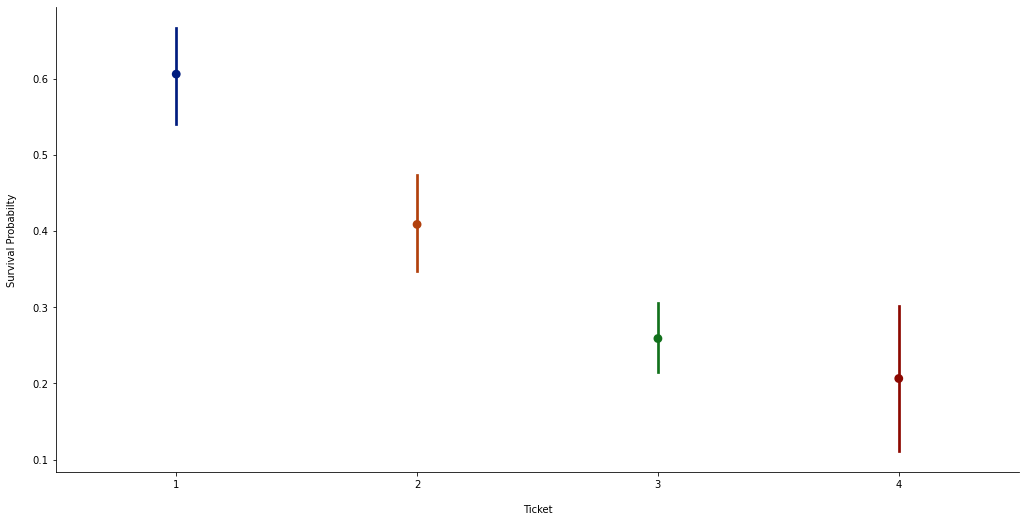

In [236]:
factorplot("Ticket")

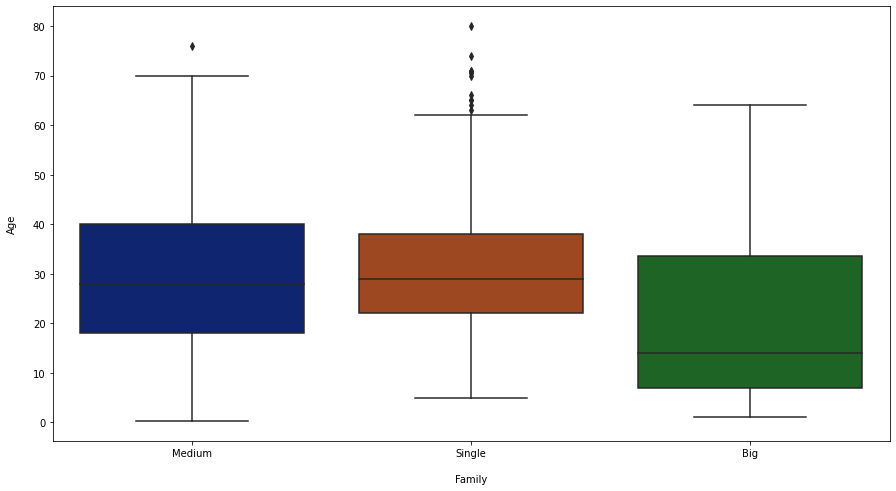

In [237]:
# Age
boxplot("Family", "Age")


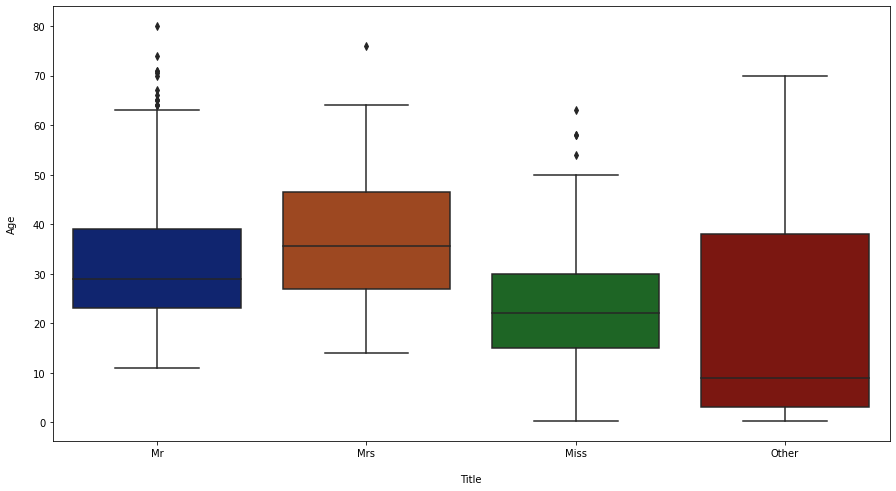

In [238]:
boxplot("Title", "Age")


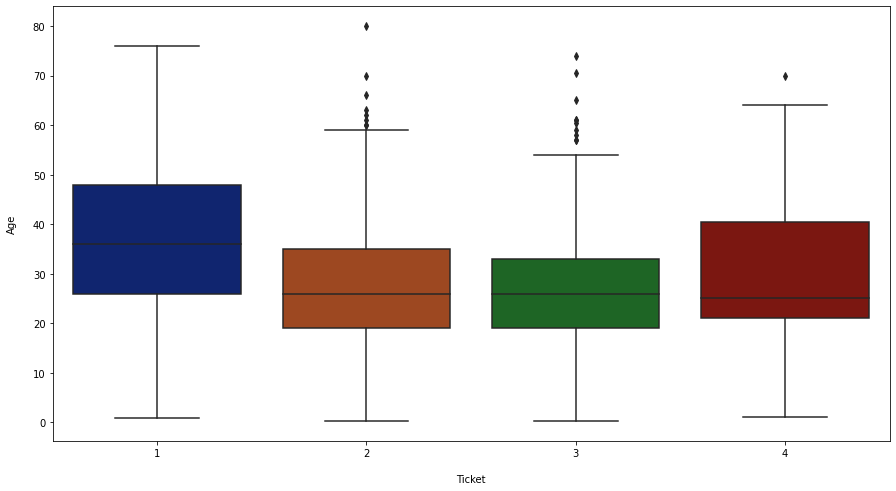

In [239]:
boxplot("Ticket", "Age")


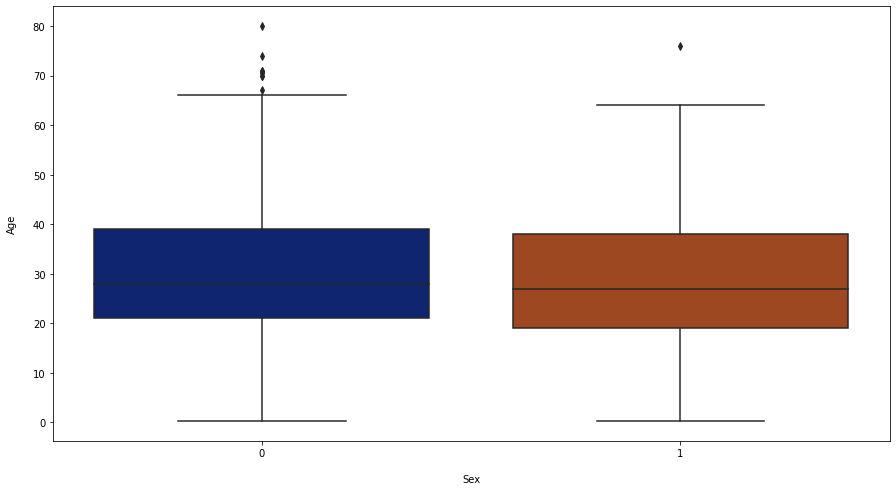

In [240]:
boxplot("Sex", "Age")


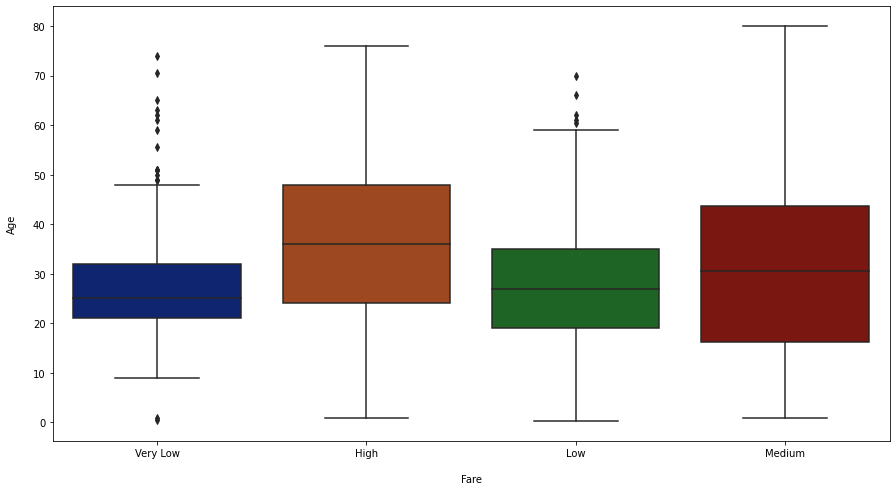

In [241]:
boxplot("Fare", "Age")


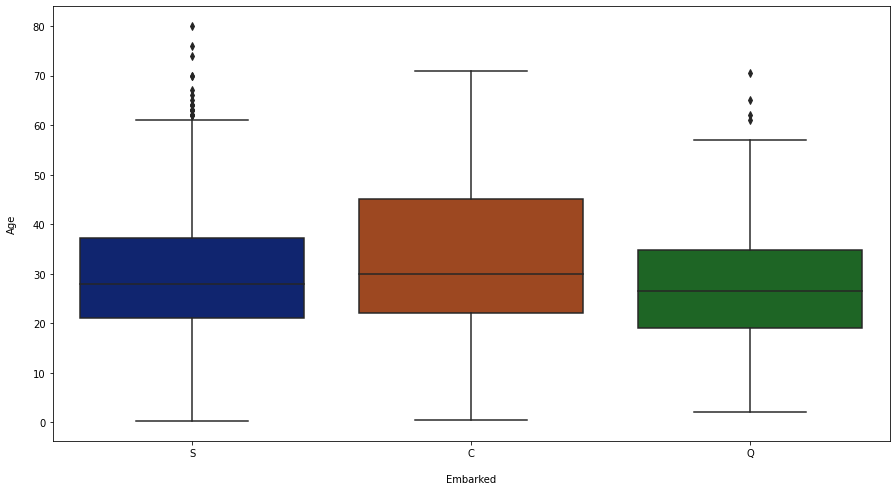

In [242]:
boxplot("Embarked", "Age")


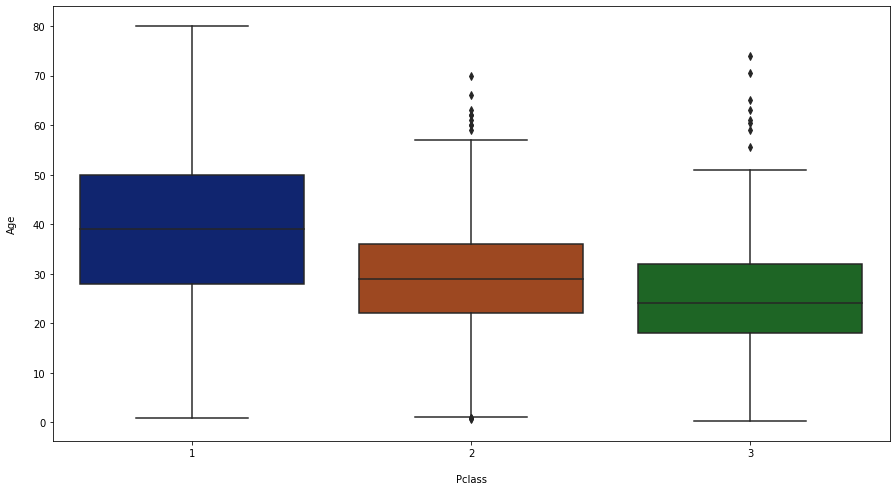

In [243]:
boxplot("Pclass", "Age")

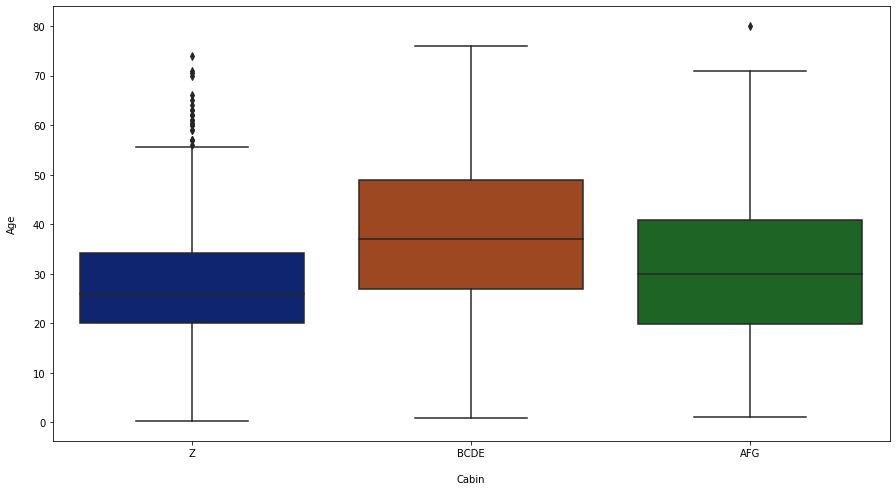

In [244]:
boxplot("Cabin", "Age")

In [245]:
dataset.Age.isnull().sum()

263

In [254]:
age_medians = pd.DataFrame(dataset.groupby(['Pclass', 'Title'])['Age'].median())
age_medians

Age
Pclass Title      
1      Miss   30.0
       Mr     41.5
       Mrs    45.0
       Other  42.0
2      Miss   20.0
       Mr     30.0
       Mrs    30.5
       Other  15.5
3      Miss   18.0
       Mr     26.0
       Mrs    31.0
       Other   6.0

In [250]:
ages = []
for i in dataset[dataset.Age.isnull() == True][["Pclass","Title"]].values:
    ages.append(age_medians.loc[(i[0],  i[1])].Age)
    
dataset.Age[dataset.Age.isnull() == True] = ages

In [255]:
index = dataset[dataset.Age.isnull() == True].index
train_idx = index[index <= 890]
test_idx = index[index > 890]

train['Age'][train.index.isin(train_idx)] = dataset['Age'][dataset.index.isin(train_idx)].values
test['Age'][test.index.isin(test_idx - 891)] = dataset['Age'][dataset.index.isin(test_idx)].values

In [256]:
ages = []
for i in dataset.Age:
    if i < 18:
        ages.append('less_18')
    elif i >= 18 and i < 50:
        ages.append('18_50')
    else:
        ages.append('greater_50')

dataset.Age = ages

ages = []
for i in train.Age:
    if i < 18:
        ages.append('less_18')
    elif i >= 18 and i < 50:
        ages.append('18_50')
    else:
        ages.append('greater_50')

train.Age = ages

ages = []
for i in test.Age:
    if i < 18:
        ages.append('less_18')
    elif i >= 18 and i < 50:
        ages.append('18_50')
    else:
        ages.append('greater_50')

test.Age = ages

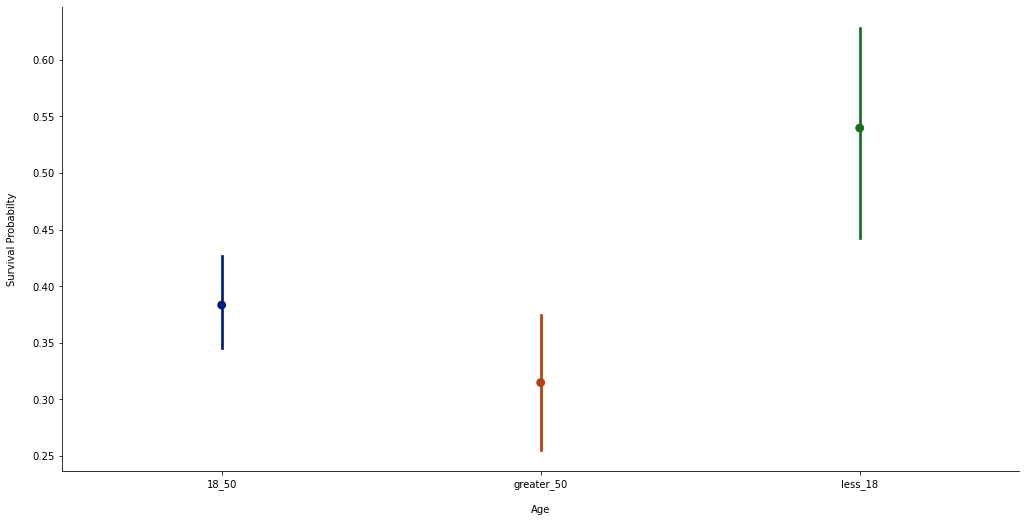

In [257]:
factorplot("Age")

#### train test split

In [259]:
X_train = train.loc[:, ~train.columns.isin(['PassengerId', 'Survived', 'Sex'])]
y_train = train.Survived
X_test = test.loc[:, ~test.columns.isin(['PassengerId', 'Survived', 'Sex'])]

In [261]:
X_train.head()

,Pclass,Age,Ticket,Fare,Cabin,Embarked,Family,Title
0,3,18_50,2,Very Low,Z,S,Medium,Mr
1,1,18_50,1,High,BCDE,C,Medium,Mrs
2,3,18_50,3,Very Low,Z,S,Single,Miss
3,1,18_50,1,High,BCDE,S,Medium,Mrs
4,3,18_50,3,Very Low,Z,S,Single,Mr


In [263]:
X_train = pd.get_dummies(X_train)
X_train["Sex"] = train.Sex 
X_test = pd.get_dummies(X_test)
X_test["Sex"] = test.Sex 

In [264]:
# FEature importance

RF = RandomForestClassifier()
RF.fit(X_train, y_train)

RandomForestClassifier()

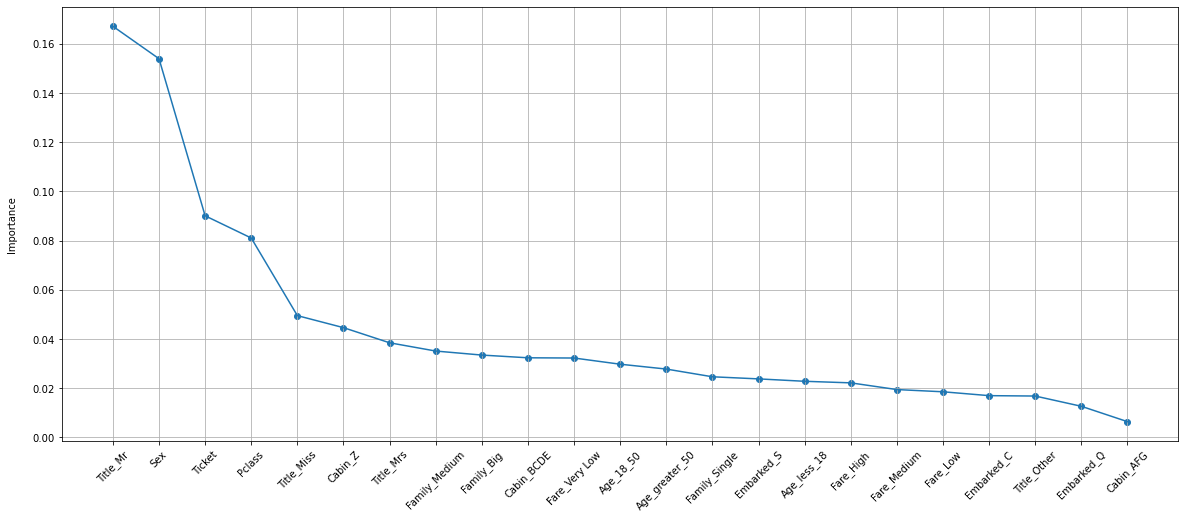

In [272]:
feature_importances = pd.DataFrame(RF.feature_importances_,
                                   index = X_train.columns,
                                   columns=['feature_importance']).sort_values('feature_importance',ascending=False)
plt.figure(figsize=(20,8))
plt.xticks(rotation=45)
plt.plot(feature_importances)
plt.scatter(y=feature_importances.feature_importance,x=feature_importances.index)
plt.ylabel('Importance\n')
plt.grid()
plt.show()

In [274]:
# ADABOOST
ABC = AdaBoostClassifier(DecisionTreeClassifier())

ABC_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
                  "base_estimator__splitter" :   ["best", "random"],
                  "algorithm" : ["SAMME","SAMME.R"],
                  "n_estimators" :[5,6,7,8,9,10,20],
                  "learning_rate":  [0.001, 0.01, 0.1, 0.3]}

gsABC = GridSearchCV(ABC, param_grid = ABC_param_grid, cv = 10, scoring = "accuracy", n_jobs = 6, verbose = 1)

gsABC.fit(X_train,y_train)

ada_best = gsABC.best_estimator_

gsABC.best_score_

Fitting 10 folds for each of 224 candidates, totalling 2240 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  92 tasks      | elapsed:    0.7s
[Parallel(n_jobs=6)]: Done 692 tasks      | elapsed:    5.6s
[Parallel(n_jobs=6)]: Done 1692 tasks      | elapsed:   14.7s
[Parallel(n_jobs=6)]: Done 2240 out of 2240 | elapsed:   20.1s finished


0.8159425717852684

In [275]:
#Extratrees
ExtC = ExtraTreesClassifier()

ex_param_grid = {"max_depth": [3, 4, 5],
                 "max_features": [3, 10, 15],
                 "min_samples_split": [2, 3, 4],
                 "min_samples_leaf": [1, 2],
                 "bootstrap": [False,True],
                 "n_estimators" :[100,200,300],
                 "criterion": ["gini","entropy"]}

gsExtC = GridSearchCV(ExtC, param_grid = ex_param_grid, cv = 10, scoring = "accuracy", n_jobs = 6, verbose = 1)

gsExtC.fit(X_train,y_train)

ext_best = gsExtC.best_estimator_

gsExtC.best_score_

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 648 candidates, totalling 6480 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.5s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   13.4s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   33.5s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:  6.0min
[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 4988 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 6038 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 6480 out of 6480 | elapsed: 11.8min finished


0.8350187265917601

In [276]:
#Random Forest
rf_test = {"max_depth": [24,26],
           "max_features": [6,8,10],
           "min_samples_split": [3,4],
           "min_samples_leaf": [3,4],
           "bootstrap": [True],
           "n_estimators" :[50,80],
           "criterion": ["gini","entropy"],
           "max_leaf_nodes":[26,28],
           "min_impurity_decrease":[0.0],
           "min_weight_fraction_leaf":[0.0]}

tuning = GridSearchCV(estimator = RandomForestClassifier(), param_grid = rf_test, scoring = 'accuracy', n_jobs = 6, cv = 10)

tuning.fit(X_train,np.ravel(y_train))

rf_best = tuning.best_estimator_

tuning.best_score_

0.8339076154806492

In [277]:
# Gradient Boost
GBM = GradientBoostingClassifier()

gb_param_grid = {'loss' : ["deviance"],
                 'n_estimators' : [450,460,500],
                 'learning_rate': [0.1,0.11],
                 'max_depth': [7,8],
                 'min_samples_leaf': [30,40],
                 'max_features': [0.1,0.4,0.6]}

gsGBC = GridSearchCV(GBM, param_grid = gb_param_grid, cv = 10, scoring = "accuracy", n_jobs = 6, verbose = 1)

gsGBC.fit(X_train,y_train)

gbm_best = gsGBC.best_estimator_

gsGBC.best_score_


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.4s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   26.9s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 720 out of 720 | elapsed:  1.7min finished


0.8361423220973782

In [278]:
#SVC

SVMC = SVC(probability=True)

svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [0.027,0.029,0.03,0.031],
                  'C': [45,55,76,77,78,85,95,100],
                  'tol':[0.001,0.0008,0.0009,0.0011]}

gsSVMC = GridSearchCV(SVMC, param_grid = svc_param_grid, cv = 10, scoring = "accuracy", n_jobs = 6, verbose = 1)

gsSVMC.fit(X_train,y_train)

svm_best = gsSVMC.best_estimator_

gsSVMC.best_score_

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.5s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    7.6s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   19.3s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:   36.8s
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 1280 out of 1280 | elapsed:  1.1min finished


0.8170661672908863

In [279]:
# XGBOOSt
XGB = XGBClassifier()

xgb_param_grid = {'learning_rate': [0.1,0.04,0.01], 
                  'max_depth': [5,6,7],
                  'n_estimators': [350,400,450,2000], 
                  'gamma': [0,1,5,8],
                  'subsample': [0.8,0.95,1.0]}

gsXBC = GridSearchCV(XGB, param_grid = xgb_param_grid, cv = 10, scoring = "accuracy", n_jobs = 6, verbose = 1)

gsXBC.fit(X_train,y_train)

xgb_best = gsXBC.best_estimator_

gsXBC.best_score_

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    9.6s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed: 16.9min
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed: 22.9min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed: 30.0min
[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed: 38.1min
[Parallel(n_jobs=6)]: Done 4320 out of 4320 | elapsed: 41.2min finished


[01:30:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8305368289637952

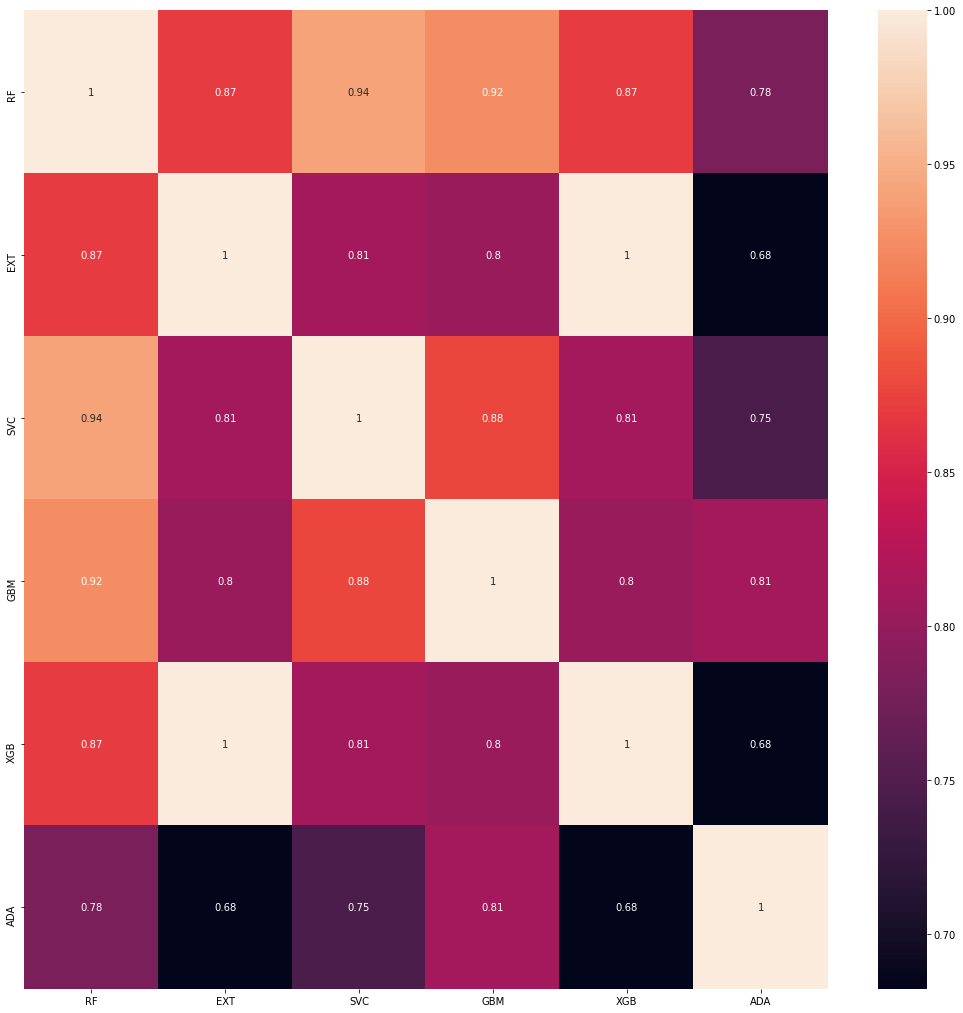

In [282]:
corr = pd.concat([pd.Series(rf_best.predict(X_test), name="RF"),
                              pd.Series(ext_best.predict(X_test), name="EXT"),
                              pd.Series(svm_best.predict(X_test), name="SVC"), 
                              pd.Series(gbm_best.predict(X_test), name="GBM"),
                              pd.Series(xgb_best.predict(X_test), name="XGB"),
                              pd.Series(ada_best.predict(X_test), name="ADA")],axis=1)

plt.figure(figsize=(18,18))
sns.heatmap(corr.corr(),annot=True)
plt.show()

## Voting Classifier

In [283]:
voting = VotingClassifier(estimators=[('rfc', rf_best), 
                                      ('extc', ext_best),
                                      ('svc', svm_best),
                                      ('gbc',gbm_best),
                                      ('xgbc',xgb_best),
                                      ('ada',ada_best)])

v_param_grid = {'voting':['soft',
                          'hard']} # tuning voting parameter

gsV = GridSearchCV(voting, 
                   param_grid = v_param_grid, cv = 10, 
                   scoring = "accuracy",
                   n_jobs = 6, 
                   verbose = 1)

gsV.fit(X_train,y_train)

v_best = gsV.best_estimator_

gsV.best_score_

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    9.8s finished


[01:33:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8271785268414481

In [287]:
pred = v_best.predict(X_test)

result_data = pd.DataFrame(test.PassengerId)
result_data["Survived"] = pd.Series(pred)

In [290]:
result_data["Original_result"] =gender_submission.Survived

In [291]:
result_data

,PassengerId,Survived,Original_result
0,892,0,0
1,893,1,1
2,894,0,0
3,895,0,0
4,896,1,1
...,...,...,...
413,1305,0,0
414,1306,1,1
415,1307,0,0
416,1308,0,0


In [296]:
incorrect = result_data[result_data.Survived != result_data.Original_result]

In [297]:
incorrect.shape

(40, 3)

In [298]:
incorrect

,PassengerId,Survived,Original_result
18,910,0,1
21,913,1,0
36,928,0,1
37,929,0,1
64,956,1,0
72,964,0,1
80,972,1,0
87,979,0,1
89,981,1,0
98,990,0,1


ref: https://www.kaggle.com/avelinocaio/top-5-voting-classifier-in-python/notebook